In [2]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 39 kB/s 
     |████████████████████████████████| 199 kB 69.9 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=7af4e97160ff6f35657c42df3bd195bb1891ca07d5161f46137a9185323734e1
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [3]:
import pyspark
from pyspark import *
from pyspark.sql.functions import *
from pyspark.sql import *
from pyspark import SparkContext, SparkConf

In [4]:
conf = SparkConf().setAppName('Elephas_Test').setMaster('local[8]')
sc = SparkContext(conf=conf)
spark = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:114: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning,


In [5]:
import os 
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

In [6]:
from google.colab import drive
from google.cloud import storage

In [7]:
os.environ["GOOGLE_CLOUD_PROJECT"] = 'pyspark_ann'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [8]:
storage_client = storage.Client(project='pyspark_ann')

In [9]:
drive.mount('consumer_complaint',force_remount=True)

Mounted at consumer_complaint


In [10]:
data_path = '/content/consumer_complaint/MyDrive/consumer_complaint'

In [11]:
import zipfile
import plotly.express as pe

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
archive = zipfile.ZipFile(data_path + '/' + 'archive_2.zip','r')

In [14]:
data_archive = archive.open('rows.csv')

In [15]:
dataset = pd.read_csv(data_archive)

In [16]:
dataset

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,05/10/2019,Checking or savings account,Checking account,Managing an account,Problem using a debit or ATM card,NaN,NaN,NAVY FEDERAL CREDIT UNION,FL,328XX,Older American,NaN,Web,05/10/2019,In progress,Yes,NaN,3238275
1,05/10/2019,Checking or savings account,Other banking product or service,Managing an account,Deposits and withdrawals,NaN,NaN,BOEING EMPLOYEES CREDIT UNION,WA,98204,NaN,NaN,Referral,05/10/2019,Closed with explanation,Yes,NaN,3238228
2,05/10/2019,Debt collection,Payday loan debt,Communication tactics,Frequent or repeated calls,NaN,NaN,CURO Intermediate Holdings,TX,751XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3237964
3,05/10/2019,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Old information reappears or never goes away,NaN,NaN,Ad Astra Recovery Services Inc,LA,708XX,NaN,NaN,Web,05/10/2019,Closed with explanation,Yes,NaN,3238479
4,05/10/2019,Checking or savings account,Checking account,Managing an account,Banking errors,NaN,NaN,ALLY FINANCIAL INC.,AZ,85205,NaN,NaN,Postal mail,05/10/2019,In progress,Yes,NaN,3238460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282350,12/01/2011,Credit card,NaN,Credit determination,NaN,NaN,NaN,"CITIBANK, N.A.",MO,63301,NaN,NaN,Web,12/02/2011,Closed with relief,Yes,No,2396
1282351,12/01/2011,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",OH,45248,NaN,NaN,Web,12/06/2011,Closed without relief,No,No,2323
1282352,12/01/2011,Credit card,NaN,Billing disputes,NaN,NaN,NaN,JPMORGAN CHASE & CO.,OH,43207,NaN,NaN,Referral,12/01/2011,Closed with relief,Yes,No,2126
1282353,12/01/2011,Mortgage,Conventional adjustable mortgage (ARM),"Loan servicing, payments, escrow account",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",CO,80920,NaN,NaN,Web,12/01/2011,Closed with relief,Yes,No,2315


In [17]:
dataset.isnull().sum()

Date received                         0
Product                               0
Sub-product                      235166
Issue                                 0
Sub-issue                        531186
Consumer complaint narrative     898791
Company public response          833273
Company                               0
State                             19400
ZIP code                         115298
Tags                            1106712
Consumer consent provided?       591701
Submitted via                         0
Date sent to company                  0
Company response to consumer          7
Timely response?                      0
Consumer disputed?               513854
Complaint ID                          0
dtype: int64

In [18]:
dataset = dataset.drop(columns=['Sub-issue','Consumer complaint narrative','Company public response',
                                'State','ZIP code','Tags'])

In [19]:
dataset = dataset.fillna('Not known')

In [20]:
dataset_s = spark.createDataFrame(dataset)

In [21]:
dataset_s.show()

+-------------+--------------------+--------------------+--------------------+--------------------+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|Date received|             Product|         Sub-product|               Issue|             Company|Consumer consent provided?|Submitted via|Date sent to company|Company response to consumer|Timely response?|Consumer disputed?|Complaint ID|
+-------------+--------------------+--------------------+--------------------+--------------------+--------------------------+-------------+--------------------+----------------------------+----------------+------------------+------------+
|   05/10/2019|Checking or savin...|    Checking account| Managing an account|NAVY FEDERAL CRED...|                 Not known|          Web|          05/10/2019|                 In progress|             Yes|         Not known|     3238275|
|   05/10/2019|Checking or savin...|Othe

In [22]:
dataset_s = dataset_s.withColumnRenamed('Consumer consent provided?','Consumer consent provided') \
.withColumnRenamed('Timely response?','Timely response') \
.withColumnRenamed('Consumer disputed?','Consumer disputed')

In [23]:
dataset_s = dataset_s.drop('Date received','Date sent to company','Complaint ID')

In [24]:
dataset_s.groupby('Consumer disputed').count().orderBy('count').show()

+-----------------+------+
|Consumer disputed| count|
+-----------------+------+
|              Yes|148378|
|        Not known|513854|
|               No|620123|
+-----------------+------+



In [25]:
consumer_disputed_dataset = dataset_s.groupby('Consumer disputed').count().orderBy('count').toPandas()

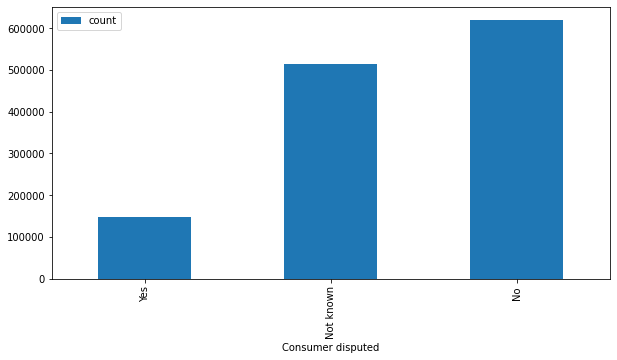

In [26]:
consumer_disputed_dataset.plot.bar(x='Consumer disputed', y='count',figsize=(10,5))

In [27]:
dataset_s.groupby('Product').count().orderBy('count').show(truncate=False)

+----------------------------------------------------------------------------+------+
|Product                                                                     |count |
+----------------------------------------------------------------------------+------+
|Virtual currency                                                            |18    |
|Other financial service                                                     |1059  |
|Prepaid card                                                                |3819  |
|Money transfers                                                             |5354  |
|Payday loan                                                                 |5544  |
|Payday loan, title loan, or personal loan                                   |8659  |
|Money transfer, virtual currency, or money service                          |10164 |
|Vehicle loan or lease                                                       |11377 |
|Consumer Loan                                        

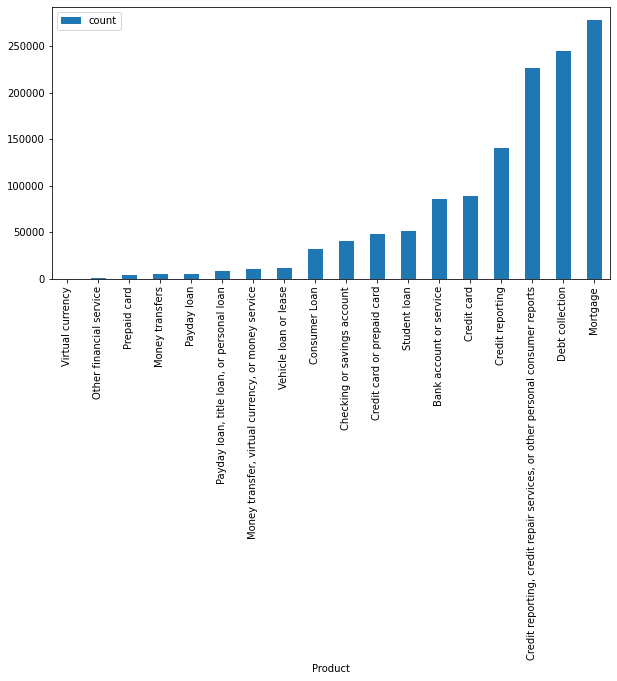

In [28]:
product_dataset = dataset_s.groupby('Product').count().orderBy('count').toPandas()
product_dataset.plot.bar(x='Product', y='count',figsize=(10,5))

In [29]:
dataset_s.groupby('Sub-product').count().orderBy('count').show(100,truncate=False)

+------------------------------------------+------+
|Sub-product                               |count |
+------------------------------------------+------+
|Student prepaid card                      |5     |
|Electronic Benefit Transfer / EBT card    |12    |
|Transit card                              |37    |
|Traveler’s/Cashier’s checks               |88    |
|Credit repair                             |103   |
|Pawn loan                                 |118   |
|Refund anticipation check                 |155   |
|Check cashing service                     |175   |
|Foreign currency exchange                 |180   |
|Gift card                                 |190   |
|Other special purpose card                |191   |
|ID prepaid card                           |207   |
|Traveler's check or cashier's check       |210   |
|Check cashing                             |266   |
|Money order                               |340   |
|Government benefit payment card           |389   |
|Gift or mer

In [30]:
dataset_s.groupby('Issue').count().orderBy('count').show(200,truncate=False)

+--------------------------------------------------------------------------------+------+
|Issue                                                                           |count |
+--------------------------------------------------------------------------------+------+
|Cannot afford Payments                                                          |1     |
|Problem with an overdraft                                                       |2     |
|Property was damaged or destroyed property                                      |3     |
|Lender damaged or destroyed property                                            |3     |
|Property was sold                                                               |5     |
|Lender sold the property                                                        |7     |
|Lender damaged or destroyed vehicle                                             |8     |
|Problem with credit report or credit score                                      |9     |
|Was appro

In [31]:
dataset_s.groupby('Company').count().orderBy(col('count').desc()).show(100,truncate=False)

+---------------------------------------------------+------+
|Company                                            |count |
+---------------------------------------------------+------+
|EQUIFAX, INC.                                      |115703|
|Experian Information Solutions Inc.                |103784|
|TRANSUNION INTERMEDIATE HOLDINGS, INC.             |96587 |
|BANK OF AMERICA, NATIONAL ASSOCIATION              |82104 |
|WELLS FARGO & COMPANY                              |70919 |
|JPMORGAN CHASE & CO.                               |60221 |
|CITIBANK, N.A.                                     |49058 |
|CAPITAL ONE FINANCIAL CORPORATION                  |34581 |
|Navient Solutions, LLC.                            |29296 |
|OCWEN LOAN SERVICING LLC                           |27750 |
|SYNCHRONY FINANCIAL                                |21925 |
|NATIONSTAR MORTGAGE                                |20449 |
|U.S. BANCORP                                       |17120 |
|Ditech Financial LLC   

In [32]:
dataset_s.groupby('Company').count().orderBy(col('count').asc()).show(100,truncate=False)

+------------------------------------------------------------+-----+
|Company                                                     |count|
+------------------------------------------------------------+-----+
|DSW Carolina, LLC d/b/a Resource Services                   |1    |
|Land Title Guarantee Company, a Colorado corporation        |1    |
|LIBERTY LENDING, LLC                                        |1    |
|LoanUnited.com, LLC                                         |1    |
|Broder Credit & Collection Service                          |1    |
|Marcadis Singer PA                                          |1    |
|Allegiance Accounting Services, LLC                         |1    |
|Bit Express, LLC                                            |1    |
|Edmonds & Logue PC                                          |1    |
|National Recovery Association, LLC.                         |1    |
|Gregg & Gregg, P.C.                                         |1    |
|Noam J. Cohen, PA                

In [33]:
dataset_s.groupby('Consumer consent provided').count().orderBy(col('count').asc()).show(100,truncate=False)

+-------------------------+------+
|Consumer consent provided|count |
+-------------------------+------+
|Consent withdrawn        |1200  |
|Other                    |20482 |
|Consent not provided     |285087|
|Consent provided         |383885|
|Not known                |591701|
+-------------------------+------+



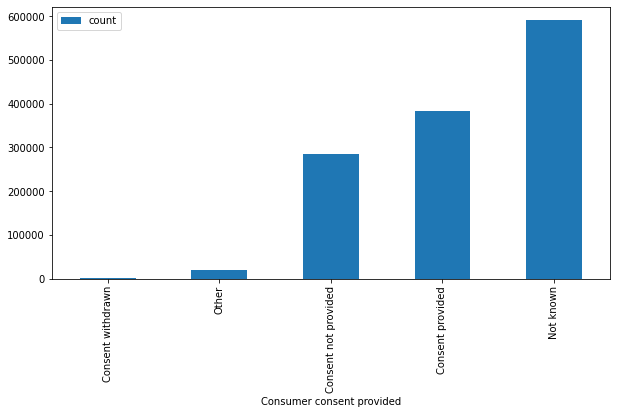

In [34]:
consent_dataset = dataset_s.groupby('Consumer consent provided').count().orderBy('count').toPandas()
consent_dataset.plot.bar(x='Consumer consent provided', y='count',figsize=(10,5))

In [35]:
dataset_s.groupby('Submitted via').count().orderBy(col('count').asc()).show(100,truncate=False)

+-------------+------+
|Submitted via|count |
+-------------+------+
|Email        |383   |
|Fax          |18972 |
|Postal mail  |67522 |
|Phone        |76509 |
|Referral     |173640|
|Web          |945329|
+-------------+------+



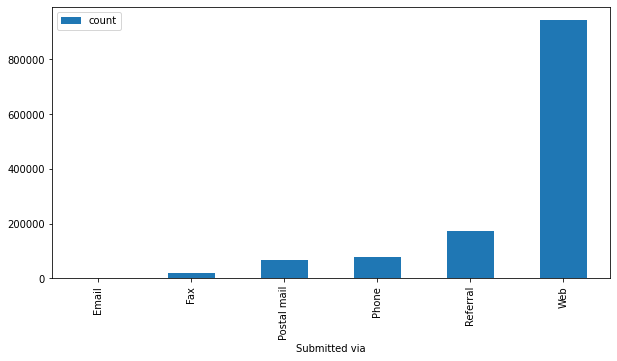

In [36]:
submitted_dataset = dataset_s.groupby('Submitted via').count().orderBy('count').toPandas()
submitted_dataset.plot.bar(x='Submitted via', y='count',figsize=(10,5))

In [37]:
dataset_s.groupby('Company response to consumer').count().orderBy(col('count').asc()).show(100,truncate=False)

+-------------------------------+------+
|Company response to consumer   |count |
+-------------------------------+------+
|Not known                      |7     |
|Closed with relief             |5304  |
|Untimely response              |6108  |
|In progress                    |9277  |
|Closed                         |17611 |
|Closed without relief          |17868 |
|Closed with monetary relief    |74243 |
|Closed with non-monetary relief|158716|
|Closed with explanation        |993221|
+-------------------------------+------+



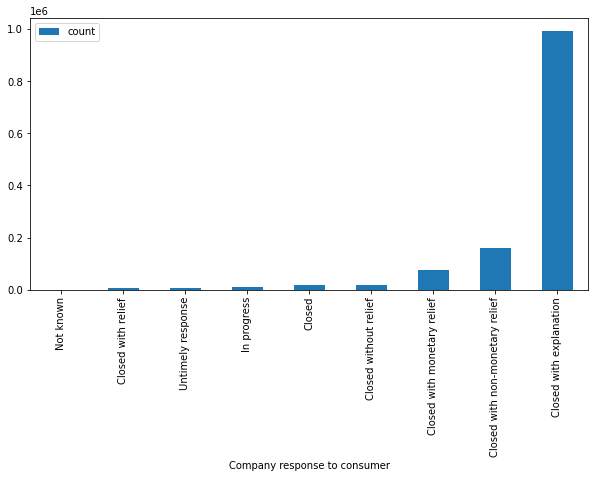

In [38]:
response_dataset = dataset_s.groupby('Company response to consumer').count().orderBy('count').toPandas()
response_dataset.plot.bar(x='Company response to consumer', y='count',figsize=(10,5))

In [39]:
dataset_s.groupby('Timely response').count().orderBy(col('count').asc()).show(100,truncate=False)

+---------------+-------+
|Timely response|count  |
+---------------+-------+
|No             |32193  |
|Yes            |1250162|
+---------------+-------+



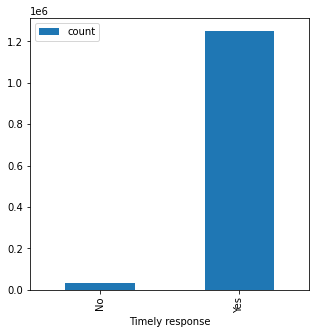

In [40]:
time_dataset = dataset_s.groupby('Timely response').count().orderBy('count').toPandas()
time_dataset.plot.bar(x='Timely response', y='count',figsize=(5,5))

In [41]:
dataset_s = dataset_s.drop(col('Company'))

In [42]:
from pyspark.ml.feature import *
from pyspark.ml.tuning import *
from pyspark.ml import *
from pyspark.ml.evaluation import *

In [43]:
cols = ['Product', 'Sub-product', 'Issue', 'Consumer consent provided',
       'Submitted via', 'Company response to consumer', 'Timely response']

In [44]:
indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in cols]

encoders = [OneHotEncoder(inputCol=indexer.getOutputCol(),outputCol="{0}_encoded".format(indexer.getOutputCol())) for indexer in indexers]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders],outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])
dataset_encoded = pipeline.fit(dataset_s).transform(dataset_s)

In [45]:
dataset_encoded_features = dataset_encoded.select(col('features'),col('Consumer disputed'))

In [46]:
indexers = [StringIndexer(inputCol='Consumer disputed', outputCol='label')]
pipeline = Pipeline(stages=indexers)
dataset_encoded_features = pipeline.fit(dataset_encoded_features).transform(dataset_encoded_features)

In [47]:
dataset_encoded_features = dataset_encoded_features.select(col('features'),col('label'))

In [48]:
train_data, test_data = dataset_encoded_features.randomSplit([0.7, 0.3], seed = 1)
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 897646
Test Dataset Count: 384709


# SPARK VERSION - LOGISTIC REGRESSION

In [49]:
from pyspark.ml.classification import LogisticRegression

In [50]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_data)

In [51]:
trainingSummary = lrModel.summary

print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.22725929823577742
label 1: 0.001656922252967955
label 2: 2.3934565417576286e-05
True positive rate by label:
label 0: 0.99813103065248
label 1: 0.9952737133997588
label 2: 0.0003178731397196937
Precision by label:
label 0: 0.8043015624825905
label 1: 0.997518741715215
label 2: 0.6346153846153846
Recall by label:
label 0: 0.99813103065248
label 1: 0.9952737133997588
label 2: 0.0003178731397196937
F-measure by label:
label 0: 0.8907943082851122
label 1: 0.9963949629621387
label 2: 0.0006354279992682951
Accuracy: 0.881585836732966
FPR: 0.11052599178712896
TPR: 0.8815858367329661
F-measure: 0.8301847168233292
Precision: 0.8621453880941301
Recall: 0.8815858367329661


In [52]:
predictions = lrModel.transform(test_data)

In [53]:
evaluator = MulticlassClassificationEvaluator()

In [54]:
accuracy = evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})
falsePositiveRate = evaluator.evaluate(predictions,{evaluator.metricName: "weightedFalsePositiveRate"})
truePositiveRate = evaluator.evaluate(predictions,{evaluator.metricName: "weightedTruePositiveRate"})
fMeasure = evaluator.evaluate(predictions,{evaluator.metricName: "weightedFMeasure"})
precision = evaluator.evaluate(predictions,{evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions,{evaluator.metricName: "weightedRecall"})
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8814168631355128
FPR: 0.11094173733293508
TPR: 0.8814168631355128
F-measure: 0.8299101399804574
Precision: 0.8502215442100782
Recall: 0.8814168631355128


# SPARK VERSION - MLPC

In [55]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [56]:
nb_classes = train_data.select('label').distinct().count()
input_dim = len(train_data.select('features').first()[0])

In [69]:
layers = [input_dim,128,256,512,nb_classes]

In [75]:
mlpc = (MultilayerPerceptronClassifier(layers=layers, solver='gd',tol=0.0001,stepSize=0.0001,blockSize=16).
        setLabelCol('label').setFeaturesCol('features').setSeed(10).setMaxIter(50))

In [76]:
model_mlpc = mlpc.fit(train_data)

In [77]:
predictions_mlpc = model_mlpc.transform(test_data)

In [78]:
evaluator_mlpc = MulticlassClassificationEvaluator()

In [79]:
accuracy = evaluator_mlpc.evaluate(predictions_mlpc,{evaluator_mlpc.metricName: "accuracy"})
falsePositiveRate = evaluator_mlpc.evaluate(predictions_mlpc,{evaluator_mlpc.metricName: "weightedFalsePositiveRate"})
truePositiveRate = evaluator_mlpc.evaluate(predictions_mlpc,{evaluator_mlpc.metricName: "weightedTruePositiveRate"})
fMeasure = evaluator_mlpc.evaluate(predictions_mlpc,{evaluator_mlpc.metricName: "weightedFMeasure"})
precision = evaluator_mlpc.evaluate(predictions_mlpc,{evaluator_mlpc.metricName: "weightedPrecision"})
recall = evaluator_mlpc.evaluate(predictions_mlpc,{evaluator_mlpc.metricName: "weightedRecall"})
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.40017779672427733
FPR: 0.40017779672427733
TPR: 0.40017779672427733
F-measure: 0.22874561982878264
Precision: 0.16014226899109701
Recall: 0.40017779672427733


# PYTORCH VERSION

In [ ]:
 pip install sparktorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sparktorch: filename=sparktorch-0.1.2-py3-none-any.whl size=24596 sha256=73aae92d01e1132cfa5bceb5fd94f6009a5a217a3c2189a16f39740b6e23b76c
  Stored in directory: /root/.cache/pip/wheels/67/d4/a2/a288b918877e28698fc8ff8cb1d8290713bd84abcb80715d47
Successfully built sparktorch


In [ ]:
from sparktorch import serialize_torch_obj, SparkTorch
import torch
import torch.nn as nn

In [ ]:
network = nn.Sequential(
    nn.Linear(input_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(),
    nn.Linear(256, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(),
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(),
    nn.Linear(256, nb_classes),
    nn.Softmax(dim=1)
)

In [ ]:
torch_obj = serialize_torch_obj(
    model=network,
    criterion=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam,
    lr=0.0001,
    weight_decay=0.0001
)

In [ ]:
spark_model = SparkTorch(
    inputCol='features',
    labelCol='label',
    predictionCol='predictions',
    torchObj=torch_obj,
    iters=20,
    verbose=2,
    miniBatch=16,
    validationPct=0.2
)

In [ ]:
p = Pipeline(stages=[spark_model])
p1 = p.fit(train_data)

In [ ]:
predictions = p1.transform(test_data).persist()
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="predictions")

In [ ]:
accuracy = evaluator.evaluate(predictions,{evaluator.metricName: "accuracy"})
falsePositiveRate = evaluator.evaluate(predictions,{evaluator.metricName: "weightedFalsePositiveRate"})
truePositiveRate = evaluator.evaluate(predictions,{evaluator.metricName: "weightedTruePositiveRate"})
fMeasure = evaluator.evaluate(predictions,{evaluator.metricName: "weightedFMeasure"})
precision = evaluator.evaluate(predictions,{evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions,{evaluator.metricName: "weightedRecall"})
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.48398659766212904
FPR: 0.48398659766212904
TPR: 0.48398659766212904
F-measure: 0.31569426177512633
Precision: 0.23424302671656355
Recall: 0.48398659766212904
